In [392]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee

In [393]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [394]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21
df['Mass_HI'] = 2.356E5 * F21 * (df.D75**2)

print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi', 'F21',
       'eF21', 'Mass_HI'],
      dtype='object', length=120)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21,Mass_HI
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,-34.024557,-34.024557,-34.024557,-34.024557,-22.164557,-21.534557,0.00,4.729334,0.805837,4.537307e+09
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,-18.127026,-18.387026,-18.597026,-18.647026,-17.657026,-17.297026,0.47,1.926637,0.134862,1.392470e+09
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,-34.620362,-34.620362,-34.620362,-34.620362,-21.020362,-20.420362,0.00,3.400948,0.579492,5.648331e+09
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,-19.921429,-20.421429,-20.701429,-20.881429,-20.301429,-19.611429,0.78,1.194538,0.203539,1.451933e+09
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,-18.364131,-18.574131,-18.674131,-18.724131,-17.714131,-17.294131,0.31,4.541507,0.317899,3.863918e+09


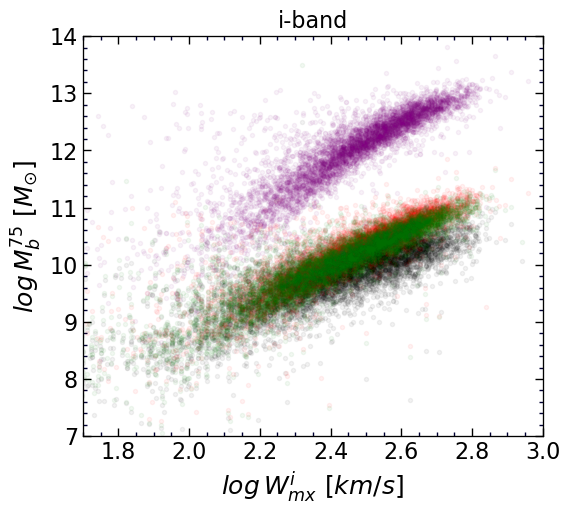

In [431]:
logMs = 0.195 + 0.882*df.gi - 0.4*df['Mi_75']
df['Mass_star'] = 10**logMs
df['Mb'] = 1.33*df['Mass_HI'] + df['Mass_star']

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()

X = dff.lgWmxi.values
Y = np.log10(dff.Mb.values)

ax.plot(X, Y, 'k.', alpha=0.05)

w = np.linspace(1.8,2.9,100)
# M = 4.378027433423001*(w-2.5) + 9.898532993058211
M = 4.285*(w-2.5) + 10.941

# ax.plot(w, M, 'r-')


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (7,14))

ax.set_title("i-band", fontsize=16)


logMs = 2. - 0.4*df['M1_75']
df['Mass_star'] = 10**logMs
df['Mb'] = 1.33*df['Mass_HI'] + df['Mass_star']
dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()
X = dff.lgWmxi.values
Y = np.log10(dff.Mb.values)
ax.plot(X, Y, 'r.', alpha=0.05)

logMs = 1.15 + 0.70*df.gi - 0.4*df['Mi_75']
df['Mass_star'] = 10**logMs
df['Mb'] = 1.33*df['Mass_HI'] + df['Mass_star']
dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()
X = dff.lgWmxi.values
Y = np.log10(dff.Mb.values)
ax.plot(X, Y, 'g.', alpha=0.05)

logMs = 3.956 - 0.4*df['M1_75']
df['Mass_star'] = 10**logMs
df['Mb'] = 1.33*df['Mass_HI'] + df['Mass_star']
dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()
X = dff.lgWmxi.values
Y = np.log10(dff.Mb.values)
ax.plot(X, Y, '.', alpha=0.05, color='purple')

In [407]:
logWe = dff.elgWi.values

logWe

array([0.011, 0.025, 0.025, ..., 0.012, 0.028, 0.031])

In [408]:
def Chi2(theta):
    
    
#     alpha = 0.70 
#     beta = 1.15 
    alpha = theta[0]
    beta = theta[1]
    slope = theta[2]
    zp = theta[3]
    ###########################################################
    
    logMs = (beta  + alpha*dff.gi) - 0.4*dff['Mi_75']
    dff['Mass_star'] = 10**logMs
    dff['Mb'] = 1.33*dff['Mass_HI'] + dff['Mass_star']
    
    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = np.log10(dff.Mb.values)
    
    logW_p = (logMass-zp)/slope+2.5
        
    chi2 = (logW-logW_p)**2/logWe**2
    
    return np.nansum(chi2)


def lnlike(theta):
    
    xi2 = Chi2(theta)
    
    return -0.5*xi2


def lnprior(theta):
    
#     if theta[1]>0.5 and theta[1]<1.5:
    if theta[2]>0 and theta[2]<10:   # slope
            if theta[3]>0 and theta[3]<20: # zp
                return 0

    return -np.inf


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [409]:
# %%time
# # res = Chi2([0.70, 1.15, 0.5, 0.5])
# res = Chi2([4.378027433423001, 9.898532993058211])
# res

In [410]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 4, 64

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

/home/ehsan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Execution time:
0:10:39.500114


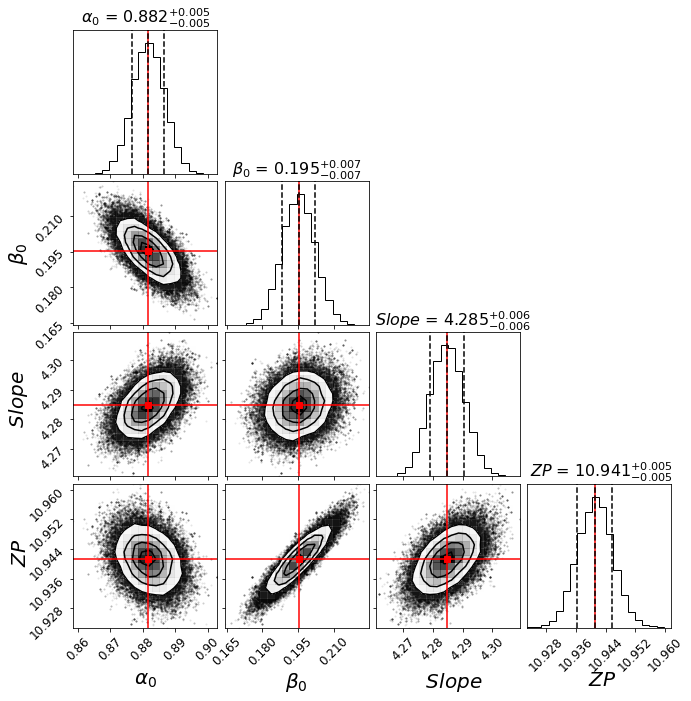

In [423]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim))

samples_ = samples

samples_ = samples_[np.where(samples_[:,0]>0.6)]

samples_ = samples_[np.where(samples_[:,1]>0.60)]
samples_ = samples_[np.where(samples_[:,2]>4)]
samples_ = samples_[np.where(samples_[:,3]<12)]


samples_[:,1] -= 0.4*4.58

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples_, 
                            [16, 50, 84],
                            axis=0)))

labels = [r"$\alpha_0$", r"$\beta_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]
# labels = [r"$\alpha_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]

truths=[t[0] for t in theta]
fig = corner.corner(samples_, truth_color='r', labels=labels,
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 16}, 
                    title_fmt=".3f")


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(20)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt) 

In [412]:
truths

[0.8817625063981949, 0.1952059719193271, 4.284783911127572, 10.941240776509549]

In [413]:
samples.shape

(192000, 4)

In [414]:
np.median(samples[:,1])

2.0249055918679737

In [415]:
samples_ = samples[np.where(samples[:,3]>6)]


In [416]:
samples_.shape

(192000, 4)